# Model Fine tuning on FUNSD dataset

In [41]:
import json
import os
import datasets
from datasets import  DatasetDict, Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D, load_metric
import pandas as pd
from PIL import Image
from transformers import LayoutLMv3Processor, logging, AdamW, LayoutLMForTokenClassification, AutoProcessor
from redactor.token_classification_wrapper import LayoutLMv3ForTokenClassification
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from torch.nn import  CrossEntropyLoss
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import pandas as pd
import argparse
from seqeval.metrics import classification_report
from seqeval.scheme import IOBES


logging.set_verbosity_error()
processor =  AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


def normalize_box(box, width, height):

    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

def create_DS(path):
  train = []
  for f in os.listdir(f'{path}/annotations'):
    if f.startswith("."):
        continue
    with open(f'{path}/annotations/{f}') as fp:
      annotation = json.load(fp)

    id = 0
    tmp = {}
    tmp['id'] = str(id)
    tmp['words'] = []
    tmp['bboxes'] = []
    tmp['ner_tags'] = []
    # tmp['idxs'] = []
    for ann in annotation['form']:
      image = f"{path}/images/{f.replace('json', 'png')}"
      tmp['image_path'] = image
      img = Image.open(image)
      width, height = img.size
  
      words, label = ann["words"], ann["label"]
      words = [w for w in words if w["text"].strip() != ""]
      if len(words) == 0:
        continue
      if label == "other":
        for w in words:
            tmp['words'].append(w['text'])
            tmp['bboxes'].append(normalize_box(w['box'], width, height))
            tmp['ner_tags'].append(label2id['O'])
      else:
          if len(words) == 1:
              tmp['words'].append(words[0]["text"])
              tmp['bboxes'].append(normalize_box(words[0]['box'], width, height))
              tmp['ner_tags'].append(label2id["S-"+label.upper()])

          else:
              tmp['words'].append(words[0]["text"])
              tmp['bboxes'].append(normalize_box(words[0]['box'], width, height))
              tmp['ner_tags'].append(label2id["B-"+label.upper()])
              for w in words[1:-1]:
                  tmp['words'].append(w["text"])
                  tmp['bboxes'].append(normalize_box(w['box'], width, height))
                  tmp['ner_tags'].append(label2id["I-"+label.upper()])

              tmp['words'].append(words[-1]["text"])
              tmp['bboxes'].append(normalize_box(words[-1]['box'], width, height))
              tmp['ner_tags'].append(label2id["E-"+label.upper()])

      
    train.append(tmp)
    id += 1
  df = pd.DataFrame(data=train)
  return df



def preprocess_data(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    words = examples['words']
    boxes = examples['bboxes']
    word_labels = examples['ner_tags']
    encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                             padding="max_length", truncation=True)
  
    return encoded_inputs


In [42]:
def do_eval(model, dataloader_eval):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # put model in evaluation mode
    model.eval()
    final_predictions = []
    final_true = []
    for batch in tqdm(dataloader_eval, desc="Evaluating"):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            bbox = batch['bbox'].to(device)
            image = batch['pixel_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(**batch) 
            
            eval_loss = outputs.loss
            # predictions
            predictions = outputs.logits.argmax(dim=2)

            # Remove ignored index (special tokens)
            true_predictions = [
                final_predictions.append([id2label[p.item()] for (p, l) in zip(prediction, label) if l != -100])
                for prediction, label in zip(predictions, labels)
            ]
            true_labels = [
                final_true.append([id2label[l.item()] for (p, l) in zip(prediction, label) if l != -100])
                for prediction, label in zip(predictions, labels)
            ]

    # print(f"Predicitons: {final_predictions}")
    # print(f"Ground Truth: {final_true}")
    final_score = classification_report(final_true, final_predictions, output_dict=True, mode='strict', scheme=IOBES)
    print(classification_report(final_true, final_predictions, output_dict=False, mode='strict', scheme=IOBES))
    final_score['eval_loss'] = eval_loss.item()
    print(f"Validation loss: {final_score['eval_loss']}")
    return final_score

def train_layoutLM(model, epochs, dataloader_train, dataloader_eval, class_weights,  optimizer, early_stop_arg, run, model_dir, results_dir):
  #args for early stop
  last_loss = 1000
  patience = early_stop_arg['patience']
  trigger_times = 0

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  global_step = 0
  num_train_epochs = epochs
  final_results = []
  #put the model in training mode
  model.train() 
  model.loss_fct=CrossEntropyLoss(weight=class_weights) 
  for epoch in range(num_train_epochs):  
    for batch in tqdm(dataloader_train, desc=f'training {epoch}/{num_train_epochs}'):
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch) 
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        global_step += 1


    print(f"Loss after {epoch} epochs: {loss.item()}")    
    eval_results = do_eval(model, dataloader_eval) 
    current_loss = eval_results['eval_loss']
    #implementing early stopping
    if current_loss > last_loss:
      trigger_times += 1
      print(f'Validation loss did not decrease from {last_loss}.')
      print('Trigger Times:', trigger_times)

      if trigger_times >= patience:
          print(f'Early stopping because validation loss did not decrease after {trigger_times} epochs.')
          print(f'Returning best model named: {best_model}')
          best_model = torch.load(best_model)
          df = pd.DataFrame(final_results)
          df.to_csv(f'{results_dir}/log_FUNSD_run{run}.csv', index = False)
          return best_model

    else:
      print(f'Validation loss decresed. Saving checkpoint...')
      best_model = f'{model_dir}/checkpointLMv3_epoch{epoch}.pt'
      for ckpt in os.listdir(model_dir):
          if 'checkpointLMv3_epoch' in ckpt:
              os.remove(f'{model_dir}/{ckpt}') #avoid too many checkpoints
      torch.save(model, best_model)
      trigger_times = 0
      last_loss = current_loss

    tmp = eval_results
    tmp['epoch'] =  epoch
    tmp['train_loss'] =  loss.item()
    final_results.append(tmp)
    
  df = pd.DataFrame(final_results)
  df.to_csv(f'{results_dir}/log_FUNSD_run{run}.csv', index = False)
  best_model = torch.load(best_model)
  return best_model

In [43]:
LABELS=[
    # "S-ANSWER","E-HEADER","B-HEADER","E-QUESTION","O","E-ANSWER","B-QUESTION","B-ANSWER","S-HEADER","I-ANSWER","I-HEADER","I-QUESTION","S-QUESTION",
        "O","I-NAME","B-NAME","E-NAME","S-NAME","I-PHONE","B-PHONE","E-PHONE","S-PHONE","I-ADDRESS","B-ADDRESS","E-ADDRESS","S-ADDRESS"]
label2id =  {k.upper():v for v, k in enumerate(LABELS)}

## Preparing Data for training

In [44]:
print('preparing dataset...')
train = create_DS('/home/ec2-user/SageMaker/data/FUNSD/dataset/training_data')
test = create_DS('/home/ec2-user/SageMaker/data/FUNSD/dataset/testing_data')

print(f'trainig split: {len(train)}')
print(f'validation split: {len(test)}')


features= Features({'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'id': Value(dtype='string', id=None),
 'image_path': Value(dtype='string', id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=len(label2id), names=list(label2id.keys()),id=None), length=-1, id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)})

train_ds = datasets.Dataset.from_pandas(train, features = features)
test_ds = datasets.Dataset.from_pandas(test, features = features)

labels = train_ds.features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
print(label2id)

# we need to define custom features
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})


train_dataset = train_ds.map(preprocess_data, batched=True, remove_columns=train_ds.column_names,
                                      features=features, batch_size = 8)
test_dataset = test_ds.map(preprocess_data, batched=True, remove_columns=test_ds.column_names,
                                      features=features, batch_size = 8)

train_dataset.set_format(type="torch", device='cuda')
test_dataset.set_format(type="torch", device='cuda')

train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)
eval_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=True)

preparing dataset...
trainig split: 149
validation split: 50
{'O': 0, 'I-NAME': 1, 'B-NAME': 2, 'E-NAME': 3, 'S-NAME': 4, 'I-PHONE': 5, 'B-PHONE': 6, 'E-PHONE': 7, 'S-PHONE': 8, 'I-ADDRESS': 9, 'B-ADDRESS': 10, 'E-ADDRESS': 11, 'S-ADDRESS': 12}


Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

## Start Training

In [45]:
BATCH_SIZE=2
LR=1e-5
EPOCHS=100
PATIENCE=20
RUN_ID=1

base_model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",num_labels=len(labels))
early_stop_arg = {'patience': PATIENCE}
print('starting training...')

model = train_layoutLM(base_model, EPOCHS, train_dataloader, eval_dataloader, torch.tensor([1]+[8]*(len(labels)-1),dtype=torch.float,device='cuda'),
          AdamW(base_model.parameters(), lr=LR), early_stop_arg, RUN_ID, '/home/ec2-user/SageMaker/experiments/model/','/home/ec2-user/SageMaker/experiments/results/')

torch.save(model, '/home/ec2-user/SageMaker/experiments/model/LayoutLMv3_FUNSD.pt')

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


starting training...


training 0/100:   0%|          | 0/25 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/modeling_utils.py:942: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
training 0/100: 100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Loss after 0 epochs: 1.0972405672073364


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.00      0.00      0.00       126
       PHONE       0.00      0.00      0.00        77

   micro avg       0.00      0.00      0.00       233
   macro avg       0.00      0.00      0.00       233
weighted avg       0.00      0.00      0.00       233

Validation loss: 2.360222339630127
Validation loss decresed. Saving checkpoint...


training 1/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 1 epochs: 0.7417142391204834


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.00      0.00      0.00       126
       PHONE       0.00      0.00      0.00        77

   micro avg       0.00      0.00      0.00       233
   macro avg       0.00      0.00      0.00       233
weighted avg       0.00      0.00      0.00       233

Validation loss: 1.1105446815490723
Validation loss decresed. Saving checkpoint...


training 2/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 2 epochs: 0.46343904733657837


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.53      0.44      0.48       126
       PHONE       0.00      0.00      0.00        77

   micro avg       0.53      0.24      0.33       233
   macro avg       0.18      0.15      0.16       233
weighted avg       0.29      0.24      0.26       233

Validation loss: 1.0092638731002808
Validation loss decresed. Saving checkpoint...


training 3/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 3 epochs: 0.6291670203208923


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.45      0.56      0.50       126
       PHONE       0.00      0.00      0.00        77

   micro avg       0.45      0.30      0.36       233
   macro avg       0.15      0.19      0.17       233
weighted avg       0.25      0.30      0.27       233

Validation loss: 1.7801580429077148
Validation loss did not decrease from 1.0092638731002808.
Trigger Times: 1


training 4/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 4 epochs: 0.33739739656448364


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.44      0.61      0.51       126
       PHONE       0.00      0.00      0.00        77

   micro avg       0.44      0.33      0.38       233
   macro avg       0.15      0.20      0.17       233
weighted avg       0.24      0.33      0.27       233

Validation loss: 0.3099338114261627
Validation loss decresed. Saving checkpoint...


training 5/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 5 epochs: 0.46737396717071533


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.57      0.65      0.61       126
       PHONE       0.66      0.35      0.46        77

   micro avg       0.59      0.47      0.52       233
   macro avg       0.41      0.33      0.36       233
weighted avg       0.53      0.47      0.48       233

Validation loss: 0.2485910803079605
Validation loss decresed. Saving checkpoint...


training 6/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 6 epochs: 0.5905611515045166


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.54      0.70      0.61       126
       PHONE       0.63      0.81      0.70        77

   micro avg       0.57      0.64      0.60       233
   macro avg       0.39      0.50      0.44       233
weighted avg       0.50      0.64      0.56       233

Validation loss: 1.0387274026870728
Validation loss did not decrease from 0.2485910803079605.
Trigger Times: 1


training 7/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 7 epochs: 0.9258135557174683


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.57      0.68      0.62       126
       PHONE       0.69      0.60      0.64        77

   micro avg       0.60      0.57      0.58       233
   macro avg       0.42      0.43      0.42       233
weighted avg       0.53      0.57      0.55       233

Validation loss: 0.76225346326828
Validation loss did not decrease from 0.2485910803079605.
Trigger Times: 2


training 8/100: 100%|██████████| 25/25 [00:49<00:00,  2.00s/it]


Loss after 8 epochs: 0.37360265851020813


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.62      0.65      0.64       126
       PHONE       0.65      0.74      0.69        77

   micro avg       0.63      0.60      0.61       233
   macro avg       0.42      0.46      0.44       233
weighted avg       0.55      0.60      0.57       233

Validation loss: 0.44387203454971313
Validation loss did not decrease from 0.2485910803079605.
Trigger Times: 3


training 9/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 9 epochs: 0.3242378532886505


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


              precision    recall  f1-score   support

     ADDRESS       0.00      0.00      0.00        30
        NAME       0.65      0.70      0.67       126
       PHONE       0.76      0.74      0.75        77

   micro avg       0.68      0.62      0.65       233
   macro avg       0.47      0.48      0.47       233
weighted avg       0.60      0.62      0.61       233

Validation loss: 0.3979661166667938
Validation loss did not decrease from 0.2485910803079605.
Trigger Times: 4


training 10/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 10 epochs: 0.2266542613506317


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


              precision    recall  f1-score   support

     ADDRESS       0.43      0.10      0.16        30
        NAME       0.60      0.73      0.66       126
       PHONE       0.73      0.64      0.68        77

   micro avg       0.63      0.62      0.62       233
   macro avg       0.59      0.49      0.50       233
weighted avg       0.62      0.62      0.60       233

Validation loss: 0.05464387312531471
Validation loss decresed. Saving checkpoint...


training 11/100: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Loss after 11 epochs: 0.0985352173447609


Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


              precision    recall  f1-score   support

     ADDRESS       0.36      0.13      0.20        30
        NAME       0.56      0.72      0.63       126
       PHONE       0.70      0.52      0.60        77

   micro avg       0.59      0.58      0.58       233
   macro avg       0.54      0.46      0.47       233
weighted avg       0.58      0.58      0.56       233

Validation loss: 1.7768176794052124
Validation loss did not decrease from 0.05464387312531471.
Trigger Times: 1


training 12/100:  44%|████▍     | 11/25 [00:23<00:29,  2.13s/it]


KeyboardInterrupt: 

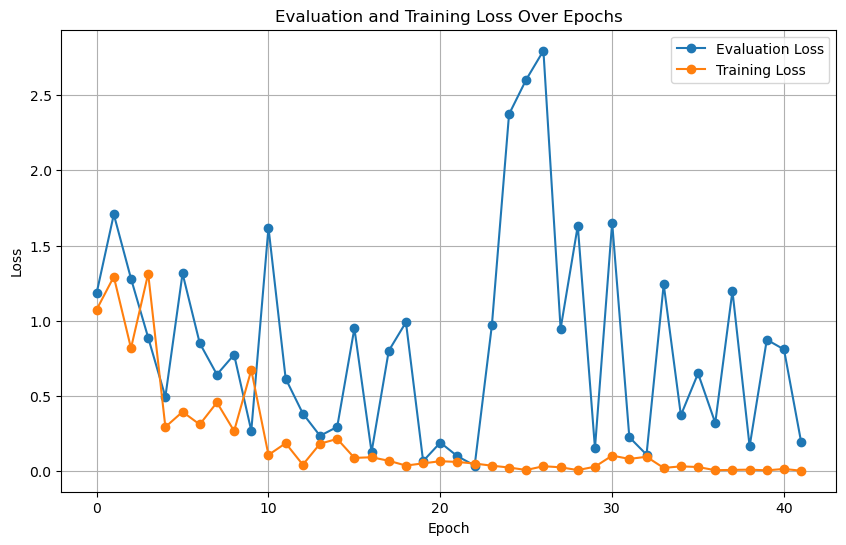

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_file.csv' with the actual path to your CSV file
csv_file_path = '/home/ec2-user/SageMaker/experiments/results/log_FUNSD_run1.csv'

# Read CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Plotting
plt.figure(figsize=(10, 6))

# Plot eval_loss
plt.plot(df['epoch'], df['eval_loss'], label='Evaluation Loss', marker='o')

# Plot train_loss
plt.plot(df['epoch'], df['train_loss'], label='Training Loss', marker='o')

# Customize the plot
plt.title('Evaluation and Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
# plt.show()
plt.savefig('/home/ec2-user/SageMaker/experiments/results/model_training_progress.png', bbox_inches='tight')



In [37]:
from tabulate import tabulate

# Your data
data = [
    ['ADDRESS', 0.38, 0.17, 0.23, 30],
    ['NAME', 0.61, 0.73, 0.66, 126],
    ['PHONE', 0.81, 0.70, 0.75, 77],
    ['', '', '', '', ''],  # Empty row
    ['micro avg', 0.65, 0.65, 0.65, 233],
    ['macro avg', 0.60, 0.53, 0.55, 233],
    ['weighted avg', 0.64, 0.65, 0.64, 233]
]

# Define headers
headers = ["", "Precision", "Recall", "F1-Score", "Support"]

# Convert data to LaTeX table
latex_table = tabulate(data, headers, tablefmt="latex_raw")

# Replace the empty row with a \cline command to draw a line
latex_table = latex_table.replace('\\hline', '\\cline{2-5}\n\\hline', 1)

# Print or use latex_table as needed in your LaTeX document
print(latex_table)


\begin{tabular}{lllll}
\cline{2-5}
\hline
              & Precision   & Recall   & F1-Score   & Support   \\
\hline
 ADDRESS      & 0.38        & 0.17     & 0.23       & 30        \\
 NAME         & 0.61        & 0.73     & 0.66       & 126       \\
 PHONE        & 0.81        & 0.7      & 0.75       & 77        \\
              &             &          &            &           \\
 micro avg    & 0.65        & 0.65     & 0.65       & 233       \\
 macro avg    & 0.6         & 0.53     & 0.55       & 233       \\
 weighted avg & 0.64        & 0.65     & 0.64       & 233       \\
\hline
\end{tabular}
